In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Alex Mallen (atmallen@uw.edu)
"""

import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import time
import xarray as xr
import datetime as dt

from torch import optim
import torch.nn as nn
from torch.fft import fftn, fftfreq

from dpk import model_objs

seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

[ Using Seed :  633  ]


so we need to fit everything in memory.

- we have to calculate the losses for every pair of (possible output, observation in batch)
- this takes a tensor of shape (batch_size, K^3, xdim) if we want backpropagation to run fast  (32*24 * 10**3 * 1038240 => 3189 GB)
- this can be divided into smaller chunks and calculated in a for loop which proportionally slows things down (space /x means time *x)
- we also have to store all intermediate values in the NN evaluation, of which the "batch size" is K^3, so however much memory is taken by applying the NN on one datapoint 


In [2]:
def get_loss(x, xhat, t_idxs):
    print("2:", time.time() - start_time)
    print(xhat.shape, x.shape)
    xhat = xhat.reshape((1, xhat.shape[0], xhat.shape[-1]))
    x = x.reshape((x.shape[0], 1, x.shape[1]))
    losses = torch.mean((x - xhat) ** 2, dim=-1)   # <-- this takes too much memory: it makes a tensor (batch_size, K^3, xdim)
    # losses = torch.empty((x.shape[0], xhat.shape[1]))
    # step = 4
    # for t in range(x.shape[0] // step):  # todo change to minibatches over time
    #     print("t", t)
    #     losses[step * t:step * (t + 1), :] = torch.mean((x[step * t: step * (t + 1), :, :] - xhat) ** 2, dim=-1)

    print("3:", time.time() - start_time)
    L = losses.reshape((x.shape[0],) + (K,) * omega_dim)  # (x.shape[0], K, ..., K)

    dims = tuple(range(-omega_dim, 0))
    Lft = fftn(L, dim=dims)
    print("4:", time.time() - start_time)

    # find frequency associated with each element of Lft
    freqs = fftfreq(K) / T
    F = torch.meshgrid(*(freqs for _ in range(omega_dim)), indexing="ij")
    t_vec = (t_idxs + 1).reshape((x.shape[0],) + (1,) * omega_dim)
    F = [f.reshape((1,) + f.shape) * t_vec for f in F]


    # ifft is the weighted sum of complex exponentials of frequency `F`
    ifft_coefs = torch.exp(complex("j") * (sum(F[i] * omegas[i] * K * T for i in range(omega_dim))))
    print("5:", time.time() - start_time)
    complex_loss = torch.sum(Lft * ifft_coefs) / (T * K**omega_dim)  
    print("6:", time.time() - start_time)
    # print("complex loss", complex_loss)
    loss = torch.real(complex_loss)  # take only real part (imag should be near 0)
    return loss


In [24]:
class FlowNet(model_objs.ModelObject):
    
    def __init__(self, xdim, num_freqs, n1=13, n2=24, n_chan=4, num_covariates=0):
        assert num_covariates == 0
        # assert xdim == 1038240

        if type(num_freqs) is int:
            num_freqs = [num_freqs]
        super(FlowNet, self).__init__(num_freqs, num_covariates)
        self.n1 = n1
        self.n2 = n2
        
        self.l1 = nn.Linear(2*num_freqs[0], 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, n1*n2)
        self.c1 = nn.Conv2d(1, n_chan, 3)
        
        self.block1 = nn.Sequential(nn.ConvTranspose2d(n_chan, n_chan, 3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        # self.block2 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh())
        
        # self.block3 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan, 3, stride = 2),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh())
        
        # self.block4 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh())
        
        # self.block5 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh(),
        #                             nn.Conv2d(n_chan, n_chan, 3, padding = 1),
        #                             nn.Tanh())
        
        self.block6 = nn.Sequential(nn.ConvTranspose2d(n_chan,8,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 1, 3, padding = 1))
        
        
    def decode(self, w):
        
        x = nn.Tanh()(self.l1(w))
        x = nn.Tanh()(self.l2(x))
        x = nn.Tanh()(self.l3(x)).reshape((-1,1,self.n1,self.n2))
        x = nn.Tanh()(self.c1(x))
        
        x = self.block1(x)
        # x = self.block2(x)
        # x = self.block3(x)
        # x = self.block4(x)
        # x = self.block5(x)
        x = self.block6(x)
        x = x[:, ..., 1:-2, 4:-4]
        x = x.flatten(start_dim=-2)
        
        return x

    def forward(self, w, data, training_mask=None):
        assert training_mask is None, "training mask not supported"
        xhat = self.decode(w)
        losses = (data.type(w.type()) - xhat) ** 2
        avg = torch.mean(losses, dim=-1)
        return avg
        

In [25]:
periods = [24, 24 * 7, 24 * 365.24]
omegas = [2 * np.pi / p for p in periods]
omega_dim = len(omegas)
xdim = 1836 # 1038240
# define a model
n1 = 11
n2 = 16
wd = 1e-3
lrt = 1e-3
model = FlowNet(xdim=xdim, num_freqs=omega_dim, n1=n1, n2=n2)
num_params = 1
num_nn_params = sum(p.numel() for p in model.parameters())
num_nn_params

81757

In [55]:
# TODO use this cell to figure out the N of NN evaluations that can be stored in mem for backprop
opt = optim.Adam(model.parameters(), lr=3e-5)
N = 1  # 1000 takes about 3GB for northeast
loss = 0
for i in range(N):
    print(f"{i + 1} of {N}")
    out = model.decode(torch.ones((1, 6), dtype=torch.float32))
    loss += torch.sum(out)
    

1 of 1


In [56]:
loss.backward()

In [57]:
torch.nn.utils.parameters_to_vector(model.parameters()).grad

c:\Users\ATMal\Documents\2021fall\NASA-GEOS\.venv\lib\site-packages\torch\_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten\src\ATen/core/TensorBody.h:417.)
  return self._grad


In [54]:
print(torch.autograd.grad(loss, torch.nn.utils.parameters_to_vector(model.parameters())))

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [22]:
model.parameters()

<generator object Module.parameters at 0x000001EA976B5430>

In [7]:
# estimates by looking at various samples of the data 
loc = -25.0
scale = 3.0  # variance attempts to account for both inter and intra sample variance

In [9]:
import pandas as pd

K = 10  # number of points within a period of the error surface to use
two_pi_linspace = torch.arange(0, K) * 2 * np.pi / K
two_pi_linspaces = torch.meshgrid(*((two_pi_linspace,) * omega_dim), indexing="ij")
flatteneds = [l.reshape(l.numel()) for l in two_pi_linspaces]
two_pi_block = torch.stack(flatteneds).T
two_pi_block
inpts = torch.cat([torch.cos(two_pi_block)] * num_params + [torch.sin(two_pi_block)] * num_params, -1)

opt = optim.Adam(model.parameters(), lr=3e-5)

num_epochs = 49
train_losses = []
times = []
start_time = time.time()
all_dates = pd.date_range(dt.datetime(2018, 1, 1), dt.datetime(2020, 1, 1), freq="D", closed="left")
T = len(all_dates) * 24
batch_size = T  # number of timesteps to load at once 

x = torch.empty((batch_size, xdim))  # allocate memory once

# train the model
for itr in range(T // batch_size):
    print("\n\n\n")
    batches = np.random.permutation(len(all_dates))
    shuffled_dates = all_dates[batches]
    t_idxs = []
    # load batch from disk
    batch = shuffled_dates[itr * (batch_size // 24):(itr + 1) * (batch_size // 24)]
    for i, current_date in enumerate(batch):
        t_idxs.extend([j + batches[i] * 24 for j in range(24)])  # append 24d, 24d+1, 24d+2,..., 24d+23
        # xrdata = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
        # darr = xrdata.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
        darr = np.load(r"D:atmo-chem/data/northeast/NO2_" + str(current_date)[:10] + ".npy")

        flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
        x_day = torch.from_numpy((np.log(flattened) - loc) / scale)
        x[i * 24:(i + 1) * 24, :] = x_day.T
    t_idxs = np.asarray(t_idxs)
    
    for epoch in range(num_epochs):
        opt.zero_grad()
        
        batch_size = len(t_idxs)
        print("1:", time.time() - start_time)
        xhat = model.decode(inpts)
        mini_size = 200  # 1100 would be 8GB for northeast
        for mini_batch in range(batch_size // mini_size):
            loss = get_loss(x[mini_batch * mini_size:(mini_batch + 1) * mini_size], xhat, t_idxs[mini_batch * mini_size:(mini_batch + 1) * mini_size])
            print("epoch:", epoch, "itr:", itr, "mini_batch:", mini_batch, "loss:", loss.detach().numpy())

            loss.backward(retain_graph=True)  # accumulate gradient. We want to discard the part of the graph after the NN only. How? I think this happens when the reference to those tensors is lost and theyre garbage collected
        print("7:", time.time() - start_time)
        train_losses.append(loss.detach())
        times.append(time.time() - start_time)
        # print(itr, train_losses[-1])
        opt.step()
        print("8:", time.time() - start_time)





1: 8.818298101425171
2: 9.46830701828003
torch.Size([1000, 1, 1836]) torch.Size([200, 1836])
3: 10.288124561309814
4: 10.290127754211426
5: 10.307125091552734
6: 10.310129165649414
epoch: 0 itr: 0 mini_batch: 0 loss: 0.026946669899784996
2: 15.902495384216309
torch.Size([1000, 1, 1836]) torch.Size([200, 1836])
3: 16.728403568267822
4: 16.748383045196533
5: 16.80243706703186
6: 16.806438207626343
epoch: 0 itr: 0 mini_batch: 1 loss: 0.02561303294806472
2: 22.694533824920654
torch.Size([1000, 1, 1836]) torch.Size([200, 1836])
3: 23.45598554611206
4: 23.45598554611206
5: 23.471654176712036
6: 23.479252815246582
epoch: 0 itr: 0 mini_batch: 2 loss: 0.026457663483916746
2: 29.206762075424194
torch.Size([1000, 1, 1836]) torch.Size([200, 1836])
3: 30.02619981765747
4: 30.028366804122925
5: 30.046374320983887
6: 30.05036950111389
epoch: 0 itr: 0 mini_batch: 3 loss: 0.02774926204161601
2: 36.26823449134827
torch.Size([1000, 1, 1836]) torch.Size([200, 1836])
3: 37.022196769714355
4: 37.0241937

In [17]:
current_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 3, 15)
H = ((end_date - current_date).days) * 24

omega_ts = torch.stack([torch.arange(len(T + H)) * omega for omega in omegas]).T
forecast_inpts = torch.cat([torch.cos(omega_ts)] * 1 + [torch.sin(omega_ts)] * 1, -1)  # todo: generalize to more omegas
params = model.output(forecast_inpts)
mean_hat = np.array(params) * scale + loc

In [18]:
mean_hat.shape

(17520, 1, 1836)

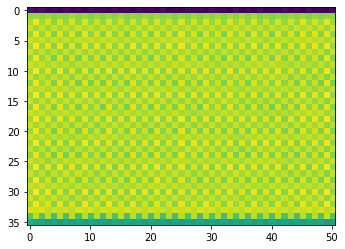

In [26]:
plt.imshow(mean_hat[10000, 0, :].reshape((36, 51)))

In [10]:
param_str = f"ConvNetNLL_{n1}_{n2}_{batch_size}_{mini_size}_{50}_{seed}_{wd}_{lrt}"
# np.save(f"forecasts/params_{param_str}.npy", np.array(params))
torch.save(model.state_dict(), f"forecasts/model_{param_str}.pt")

In [40]:
K = 10  # number of points within a period of the error surface to use
two_pi_linspace = torch.arange(0, K) * 2 * np.pi / K
two_pi_linspaces = torch.meshgrid(*((two_pi_linspace,) * omega_dim), indexing="ij")
flatteneds = [l.reshape(l.numel()) for l in two_pi_linspaces]
two_pi_block = torch.stack(flatteneds).T
two_pi_block
inpts = torch.cat([torch.cos(two_pi_block)] * num_params + [torch.sin(two_pi_block)] * num_params, -1)

opt = optim.Adam(model.parameters(), lr=3e-5)

num_epochs = 49
train_losses = []
times = []
start_time = time.time()
all_dates = pd.date_range(dt.datetime(2018, 1, 1), dt.datetime(2020, 1, 1), freq="D", closed="left")
T = len(all_dates) * 24
batch_size = T  # number of timesteps to load at once 

x = torch.empty((batch_size, xdim))  # allocate memory once

# train the model
for itr in range(T // batch_size):
    print("\n\n\n")
    batches = np.random.permutation(len(all_dates))
    shuffled_dates = all_dates[batches]
    t_idxs = []
    # load batch from disk
    batch = shuffled_dates[itr * (batch_size // 24):(itr + 1) * (batch_size // 24)]
    for i, current_date in enumerate(batch):
        t_idxs.extend([j + batches[i] * 24 for j in range(24)])  # append 24d, 24d+1, 24d+2,..., 24d+23
        # xrdata = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
        # darr = xrdata.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
        darr = np.load(r"D:atmo-chem/data/northeast/NO2_" + str(current_date)[:10] + ".npy")

        flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
        x_day = torch.from_numpy((np.log(flattened) - loc) / scale)
        x[i * 24:(i + 1) * 24, :] = x_day.T
    t_idxs = np.asarray(t_idxs)
    
    for epoch in range(num_epochs):
        opt.zero_grad()
        
        batch_size = len(t_idxs)
        print("1:", time.time() - start_time)
        xhat = model.decode(inpts)
        mini_size = 200  # 1100 would be 8GB for northeast
        for mini_batch in range(1):
            loss = get_loss(x[mini_batch * mini_size:(mini_batch + 1) * mini_size], xhat, t_idxs[mini_batch * mini_size:(mini_batch + 1) * mini_size])
            print("epoch:", epoch, "itr:", itr, "mini_batch:", mini_batch, "loss:", loss.detach().numpy())

            loss.backward(retain_graph=True)  # accumulate gradient. We want to discard the part of the graph after the NN only. How? I think this happens when the reference to those tensors is lost and theyre garbage collected
        print("7:", time.time() - start_time)
        train_losses.append(loss.detach())
        times.append(time.time() - start_time)
        # print(itr, train_losses[-1])


print(model.state_dict()["l1.weight"].grad)





1: 13.514540433883667
2: 14.260810613632202
torch.Size([1000, 1, 1836]) torch.Size([200, 1836])
3: 15.194682359695435
4: 15.194682359695435
5: 15.236979007720947
6: 15.247425317764282
epoch: 0 itr: 0 mini_batch: 0 loss: 0.024790536925876645
7: 27.096595764160156
1: 27.136606454849243
2: 27.930591106414795
torch.Size([1000, 1, 1836]) torch.Size([200, 1836])
3: 28.823081970214844
4: 28.847083568572998
5: 28.89508843421936
6: 28.903077125549316
epoch: 1 itr: 0 mini_batch: 0 loss: 0.024790536925876645
7: 35.44102621078491
1: 35.48235273361206
2: 36.2411994934082
torch.Size([1000, 1, 1836]) torch.Size([200, 1836])
3: 37.16223096847534
4: 37.18623065948486
5: 37.24224090576172
6: 37.25027275085449
epoch: 2 itr: 0 mini_batch: 0 loss: 0.024790536925876645
7: 43.38491988182068
1: 43.38491988182068
2: 44.282315492630005
torch.Size([1000, 1, 1836]) torch.Size([200, 1836])
3: 45.2987425327301
4: 45.2987425327301
5: 45.3147554397583
6: 45.32275414466858


In [ ]:
K = 3  # number of points within a period of the error surface to use
two_pi_linspace = torch.arange(0, K) * 2 * np.pi / K
two_pi_linspaces = torch.meshgrid(*((two_pi_linspace,) * omega_dim), indexing="ij")
flatteneds = [l.reshape(l.numel()) for l in two_pi_linspaces]
two_pi_block = torch.stack(flatteneds).T
two_pi_block
inpts = torch.cat([torch.cos(two_pi_block)] * num_params + [torch.sin(two_pi_block)] * num_params, -1)
fn = FlowNet(xdim=xdim, num_freqs=6)

learning_rate = 3e-4
optimizer = torch.optim.Adam(fn.parameters(), lr=learning_rate)

xhat = model.decode(inpts)

fake_loss = torch.sum(xhat)
fake_loss.backward()

In [ ]:
    
data = torch.from_numpy(np.log(np.load('ristretto/for_henning.npy'))+25.)/2.5
data = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))
inpt = torch.from_numpy(np.random.uniform(-1,1,(4,12)).astype(np.float32))
fn = FlowNet(xdim=xdim, num_freqs=6)

learning_rate = 3e-4
optimizer = torch.optim.Adam(fn.parameters(), lr=learning_rate)

for i in range(1):
    loss = fn(inpt, data)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(i, loss)

RuntimeError: grad can be implicitly created only for scalar outputs

In [7]:
loss

tensor([[1.0172, 1.0124, 1.0035, 0.9928],
        [1.0172, 1.0124, 1.0035, 0.9928],
        [1.0172, 1.0124, 1.0035, 0.9928],
        [1.0172, 1.0124, 1.0035, 0.9928]], grad_fn=<MeanBackward1>)

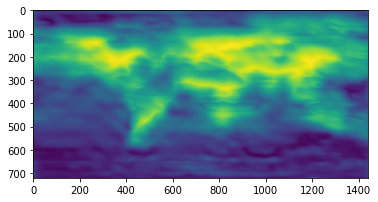

In [ ]:
x = x.detach().cpu().numpy()
plt.imshow(np.flipud(x[0]))

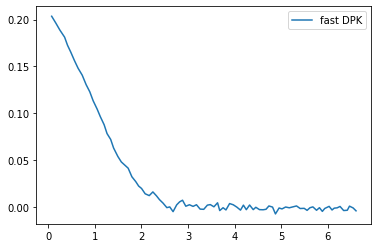

In [26]:
plt.plot(times, train_losses, label="fast DPK")
plt.legend()

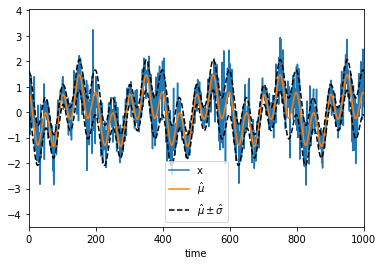

In [27]:
plt.plot(x, label="x")
omega_ts = torch.stack([torch.arange(len(x)) * omega for omega in omegas]).T
forecast_inpts = torch.cat([torch.cos(omega_ts)] * 2 + [torch.sin(omega_ts)] * 2, -1)  # todo: generalize to more omegas
params = model.output(forecast_inpts)
mean_hat = model.mean(params)
std_hat = model.std(params)
plt.plot(mean_hat, label="$\hat \mu$")
plt.plot(mean_hat + std_hat, "--k", label="$\hat \mu \pm \hat \sigma$")
plt.plot(mean_hat - std_hat, "--k")
plt.xlabel("time")
plt.xlim([0, 1000])
plt.legend()
plt.show()

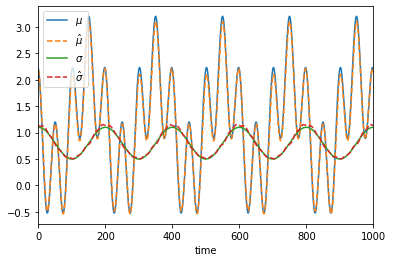

In [28]:
plt.plot(mu_t, label="$\mu$")
plt.plot(scale * mean_hat + loc, "--", label="$\hat \mu$")
plt.plot(sigma_t, label="$\sigma$")
plt.plot(scale * std_hat, "--", label="$\hat \sigma$")
plt.xlabel("time")
plt.xlim([0, 1000])
plt.legend()
plt.show()

In [ ]:
class FlowNet(model_objs.ModelObject):
    
    def __init__(self, xdim, num_freqs, n1=13, n2=24, n_chan=4, num_covariates=0):
        assert num_covariates == 0
        assert xdim == 1038240

        if type(num_freqs) is int:
            num_freqs = [num_freqs]
        super(FlowNet, self).__init__(num_freqs, num_covariates)
        self.n1 = n1
        self.n2 = n2
        
        self.l1 = nn.Linear(2*num_freqs[0], 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, n1*n2)
        self.c1 = nn.Conv2d(1, 8, 3)
        
        self.block1 = nn.Sequential(nn.ConvTranspose2d(8, n_chan, 3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        self.block2 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        self.block3 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan, 3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        self.block4 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        self.block5 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, 8, 3, padding = 1),
                                    nn.Tanh())
        
        self.block6 = nn.Sequential(nn.ConvTranspose2d(8,8,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 1, 3, padding = 1))
        
        
    def decode(self, w):
        
        x = nn.Tanh()(self.l1(w))
        x = nn.Tanh()(self.l2(x))
        x = nn.Tanh()(self.l3(x)).reshape((-1,1,self.n1,self.n2))
        x = nn.Tanh()(self.c1(x))
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)[:, ..., 23:-23, 15:-16]
        x = x.flatten(start_dim=-2)
        
        return x

    def forward(self, w, data, training_mask=None):
        assert training_mask is None, "training mask not supported"
        xhat = self.decode(w)
        losses = (data.type(w.type()) - xhat) ** 2
        avg = torch.mean(losses, dim=-1)
        return avg
        